# Problem Statement
The project analyzes the prior marketing campaign data of a Portugeuse bank and aims to predict whether the customer will subscribe to fixed-term deposit products the bank is offering.

# Dataset Description:¶
* age (numeric)
* job: type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
* marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
* education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate', 'professional.course', 'university.degree', 'unknown')
* default: has credit in default? (categorical: 'no','yes','unknown')
* housing: has housing loan? (categorical: 'no','yes','unknown')
* loan: has personal loan? (categorical: 'no','yes','unknown')
* contact: contact communication type (categorical: 'cellular','telephone')
* month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
* day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
* duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

* campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

* pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
* previous: number of contacts performed before this campaign and for this client (numeric)
* poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
* emp.var.rate: employment variation rate - quarterly indicator (numeric)
* cons.price.idx: consumer price index - monthly indicator (numeric)
* cons.conf.idx: consumer confidence index - monthly indicator (numeric)
* euribor3m: euribor 3 month rate - daily indicator (numeric)
* nr.employed: number of employees - quarterly indicator (numeric)
* y - has the client subscribed a term deposit? (binary: 'yes','no')

In [1]:
import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt
import seaborn           as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale, LabelEncoder, StandardScaler
from scipy.stats import zscore
import scipy.stats as stats
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold, StratifiedKFold
from scipy.spatial import distance
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier,AdaBoostClassifier, GradientBoostingClassifier
import io
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, f1_score, precision_score,recall_score,confusion_matrix,accuracy_score, roc_auc_score, roc_curve
from sklearn import metrics
from sklearn import model_selection
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA

In [2]:
pd.options.display.max_columns=None

pd.options.display.max_rows=None

In [3]:
# Importing the Data

df = pd.read_csv('bank-additional-full.csv',sep = ';', header = 0)


In [4]:
# Preview the Data
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [5]:
# Check the Dimensions of data
df.shape

(41188, 21)

In [6]:
# Checking Null values
df.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

In [7]:
df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [8]:
df.corr()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
age,1.000000,-0.000866,0.004594,-0.034369,0.024365,-0.000371,0.000857,0.129372,0.010767,-0.017725
duration,-0.000866,1.000000,-0.071699,-0.047577,0.020640,-0.027968,0.005312,-0.008173,-0.032897,-0.044703
campaign,0.004594,-0.071699,1.000000,0.052584,-0.079141,0.150754,0.127836,-0.013733,0.135133,0.144095
pdays,-0.034369,-0.047577,0.052584,1.000000,-0.587514,0.271004,0.078889,-0.091342,0.296899,0.372605
previous,0.024365,0.020640,-0.079141,-0.587514,1.000000,-0.420489,-0.203130,-0.050936,-0.454494,-0.501333
emp.var.rate,-0.000371,-0.027968,0.150754,0.271004,-0.420489,1.000000,0.775334,0.196041,0.972245,0.906970
cons.price.idx,0.000857,0.005312,0.127836,0.078889,-0.203130,0.775334,1.000000,0.058986,0.688230,0.522034
cons.conf.idx,0.129372,-0.008173,-0.013733,-0.091342,-0.050936,0.196041,0.058986,1.000000,0.277686,0.100513
euribor3m,0.010767,-0.032897,0.135133,0.296899,-0.454494,0.972245,0.688230,0.277686,1.000000,0.945154
nr.employed,-0.017725,-0.044703,0.144095,0.372605,-0.501333,0.906970,0.522034,0.100513,0.945154,1.000000


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
age               41188 non-null int64
job               41188 non-null object
marital           41188 non-null object
education         41188 non-null object
default           41188 non-null object
housing           41188 non-null object
loan              41188 non-null object
contact           41188 non-null object
month             41188 non-null object
day_of_week       41188 non-null object
duration          41188 non-null int64
campaign          41188 non-null int64
pdays             41188 non-null int64
previous          41188 non-null int64
poutcome          41188 non-null object
emp.var.rate      41188 non-null float64
cons.price.idx    41188 non-null float64
cons.conf.idx     41188 non-null float64
euribor3m         41188 non-null float64
nr.employed       41188 non-null float64
y                 41188 non-null object
dtypes: float64(5), int64(5), object(11)
memory usa

In [10]:
df_numerical = df.select_dtypes(exclude='object')

df_categorical= df.select_dtypes(include='object')


## Exploaratory Data Analysis
### Univariate Analysis

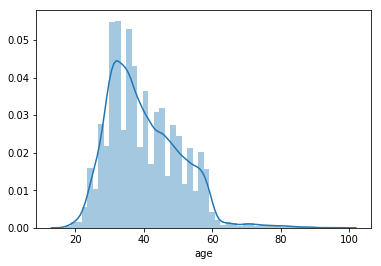

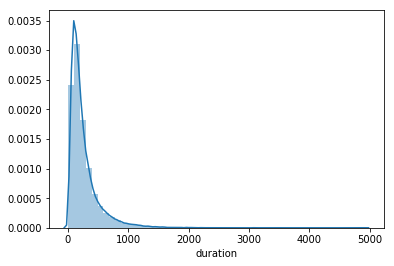

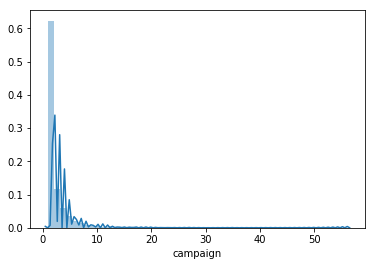

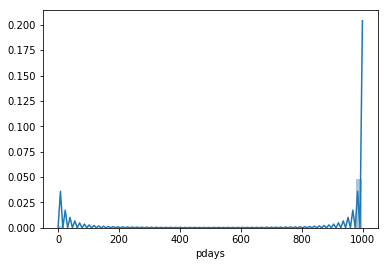

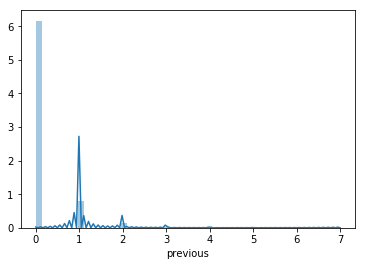

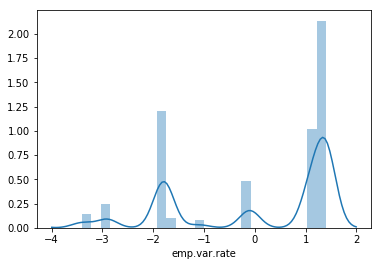

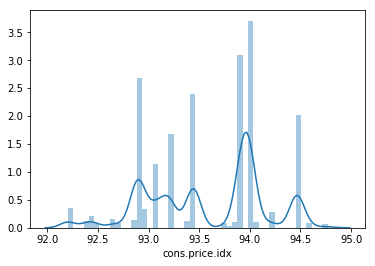

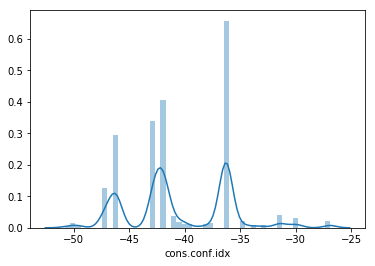

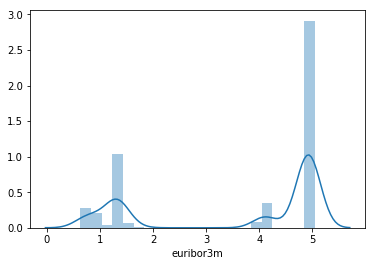

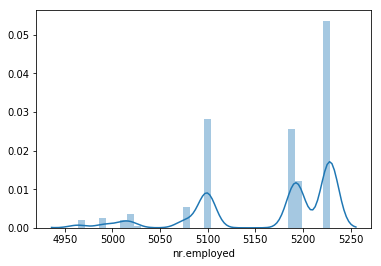

In [11]:
for i in df_numerical.columns:
    sns.distplot(df[i].dropna())
    plt.show()

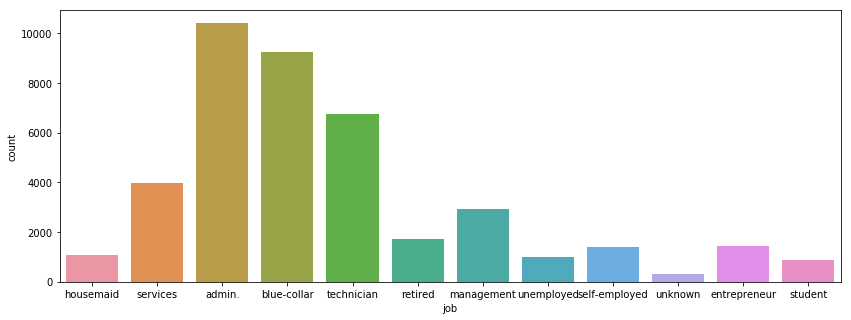

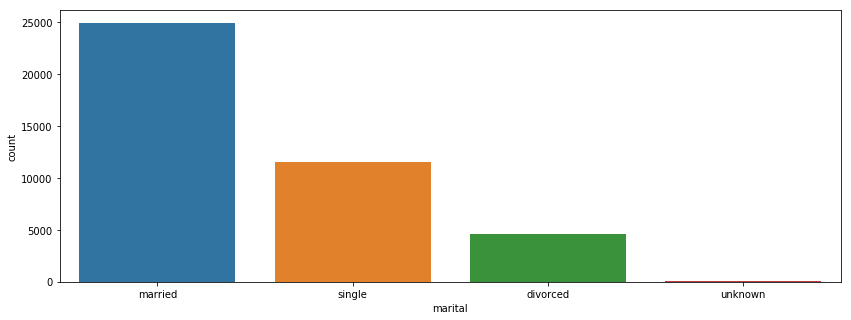

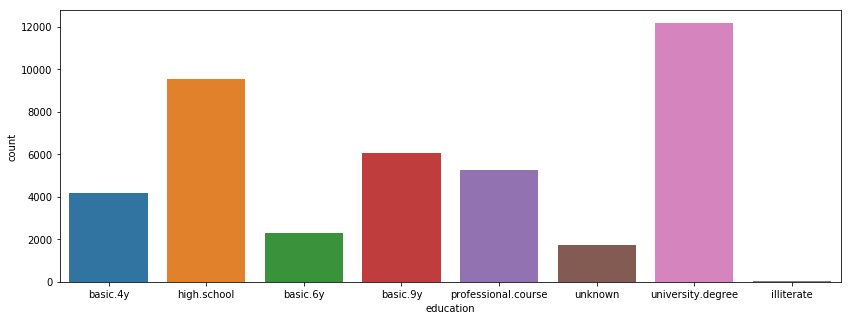

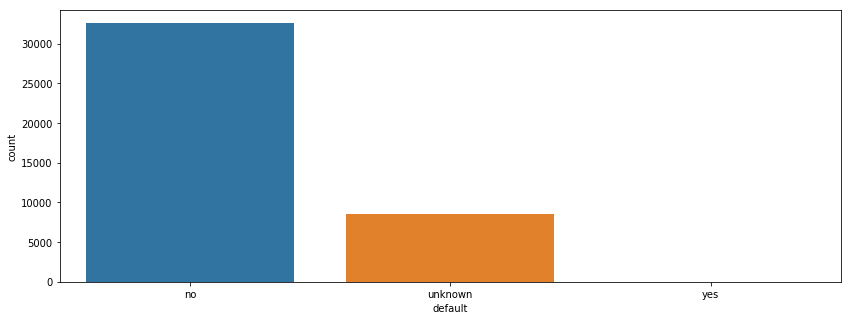

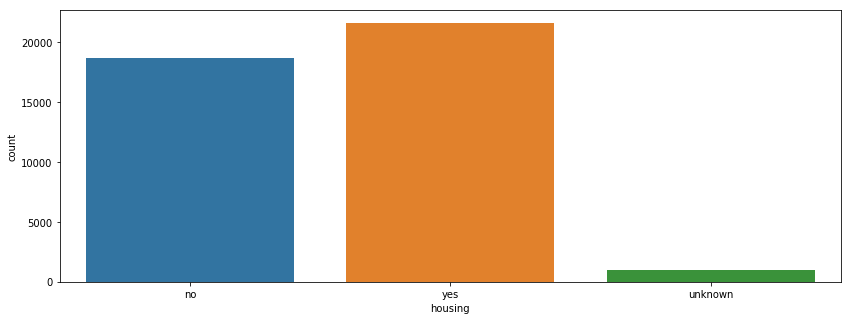

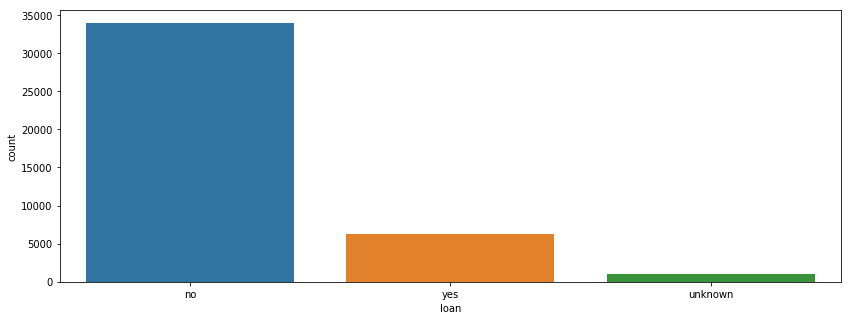

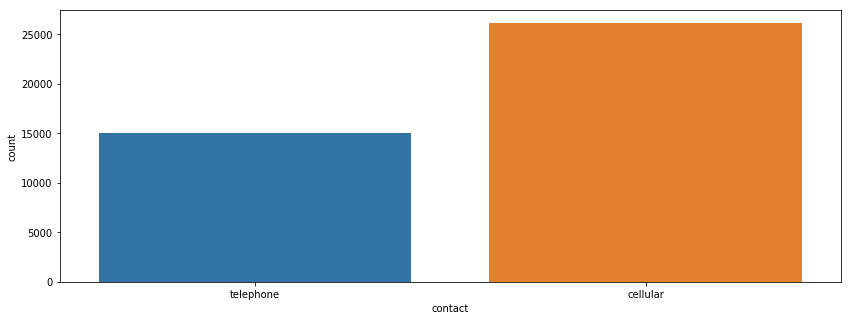

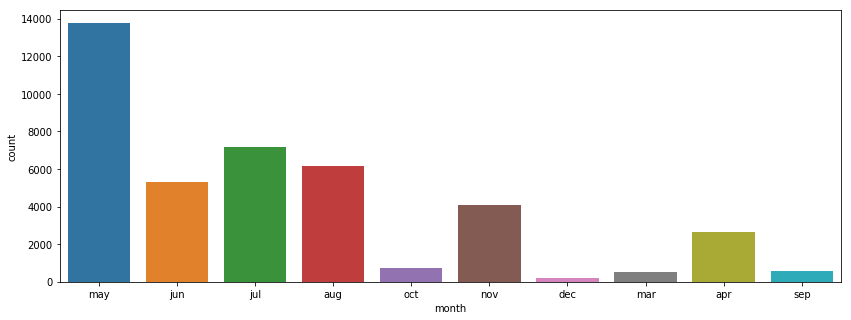

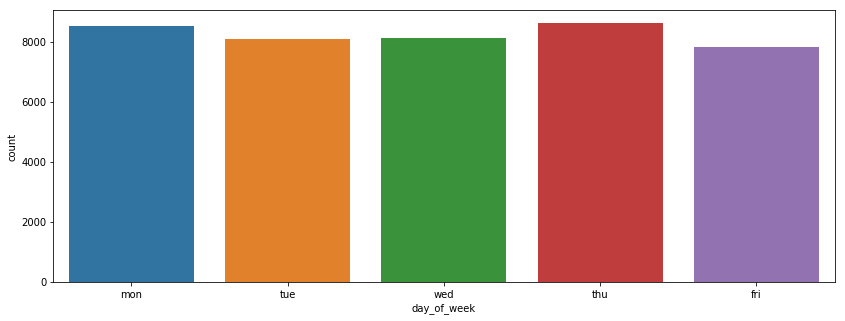

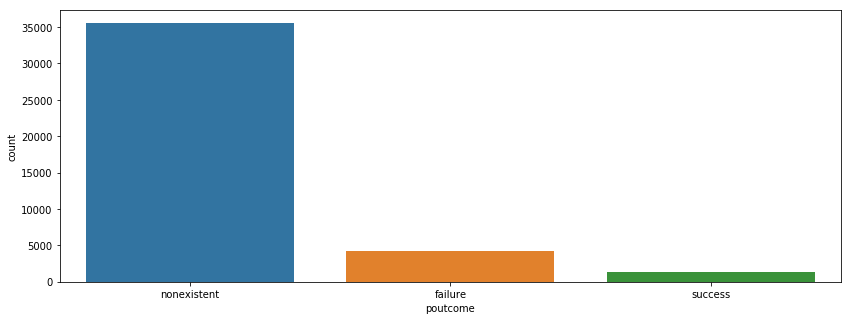

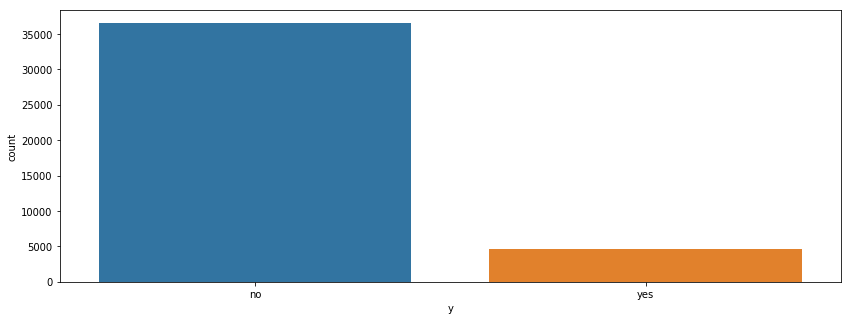

In [12]:
for i in df_categorical.columns:
    plt.figure(figsize=(14,5))
    sns.countplot(df[i].dropna())
    plt.show()

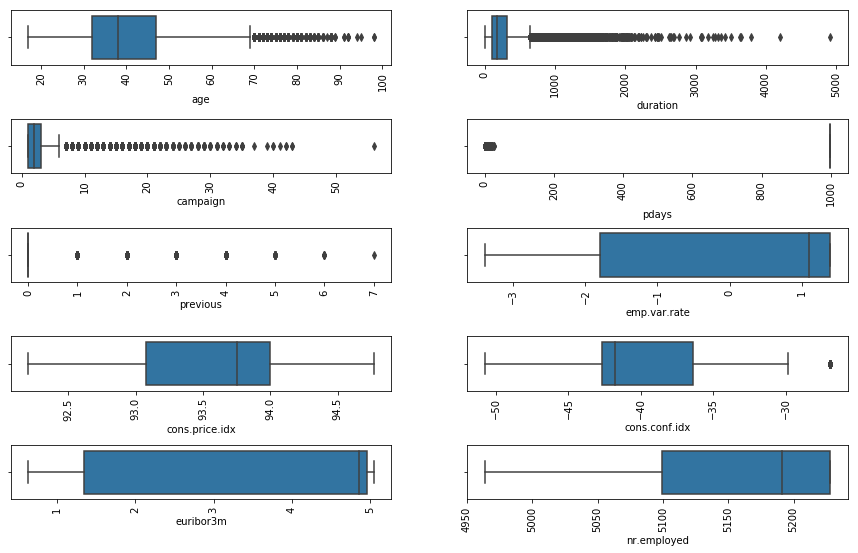

In [13]:
fig=plt.subplots(figsize=(15,15))
for i, j in enumerate(df_numerical):
    plt.subplot(8, 2, i+1)
    plt.subplots_adjust(hspace = 1.0)
    sns.boxplot(x=j,data = df)
    plt.xticks(rotation=90)
    
plt.show()

## Bivariate Analysis

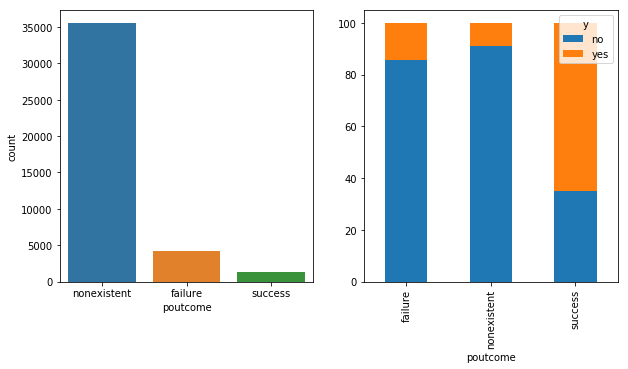

In [14]:
fig, axes= plt.subplots(1,2, figsize=(10,5))
sns.countplot(df['poutcome'], ax=axes[0])
props = (df.groupby('poutcome')['y'].value_counts(normalize=True).unstack())*100
props.plot(kind='bar', stacked='True', ax=axes[1])
plt.xticks(rotation = 90)
plt.show()

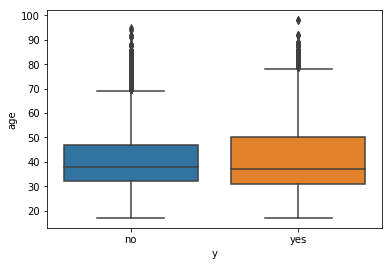

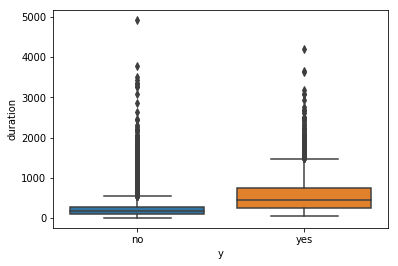

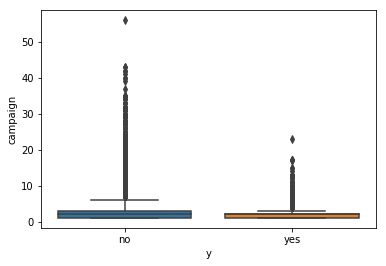

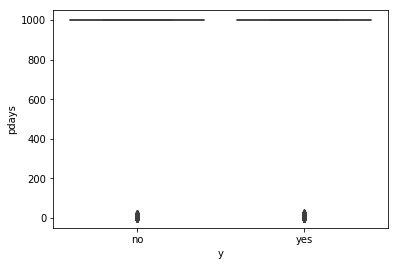

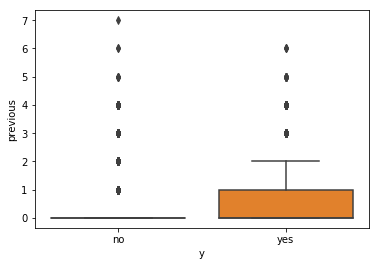

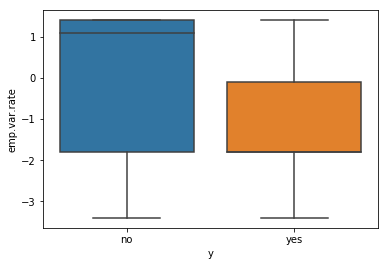

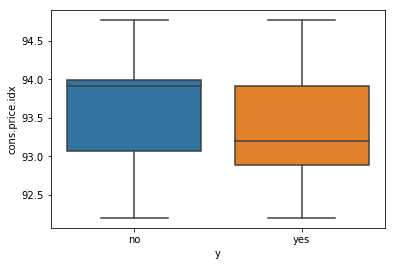

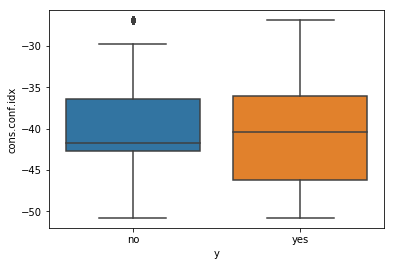

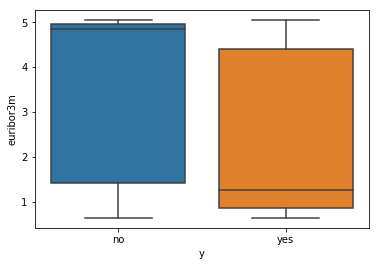

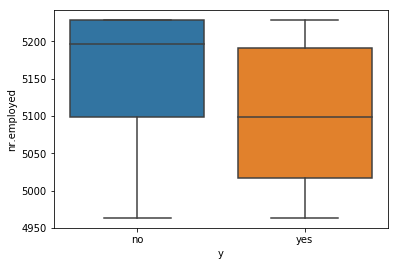

In [15]:
for i in df_numerical.columns:
    sns.boxplot(x= df['y'], y=df[i])
    plt.show()

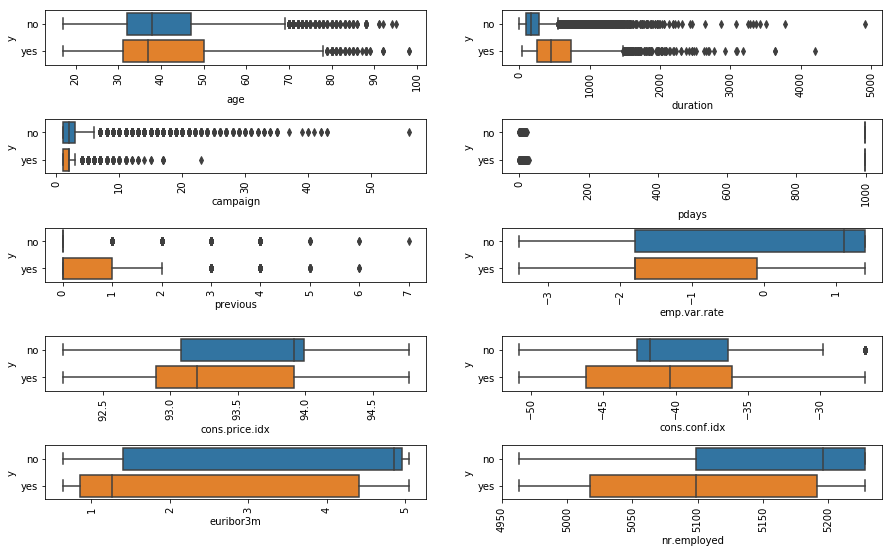

In [16]:
fig=plt.subplots(figsize=(15,15))
for i, j in enumerate(df_numerical):
    plt.subplot(8, 2, i+1)
    plt.subplots_adjust(hspace = 1.0)
    sns.boxplot(x=j, y= df['y'], data = df)
    plt.xticks(rotation=90)
    
plt.show()

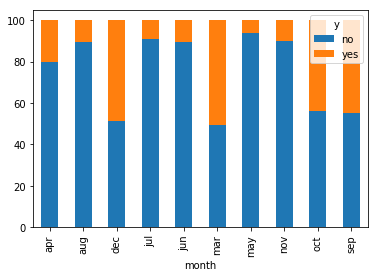

In [17]:
props = (df.groupby('month')['y'].value_counts(normalize=True).unstack())*100
props.plot(kind='bar', stacked='True')
plt.xticks(rotation = 90)
plt.show()

Text(0.5, 1.0, 'Age Distribution of Rejected Customer')

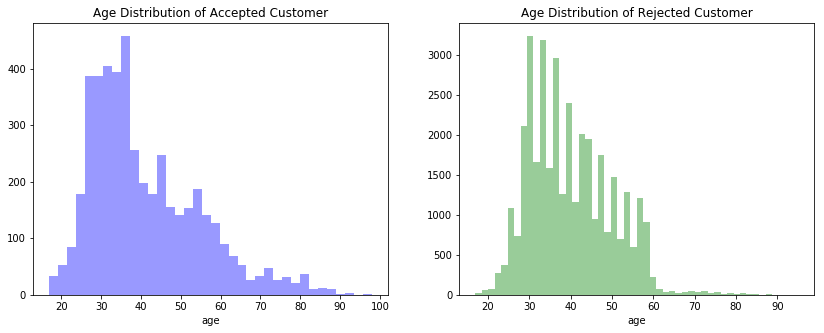

In [18]:
ageyes=df['age'][df['y']=='yes']
ageno=df['age'][df['y']=='no']
fig,axes = plt.subplots(1,2,figsize=(14,5))
sns.distplot(ageyes, kde=False, color='blue', ax=axes[0]).set_title('Age Distribution of Accepted Customer')

sns.distplot(ageno, kde=False, color='green', ax=axes[1]).set_title('Age Distribution of Rejected Customer')


Text(0.5, 1.0, 'pdays Distribution of Rejected Customer')

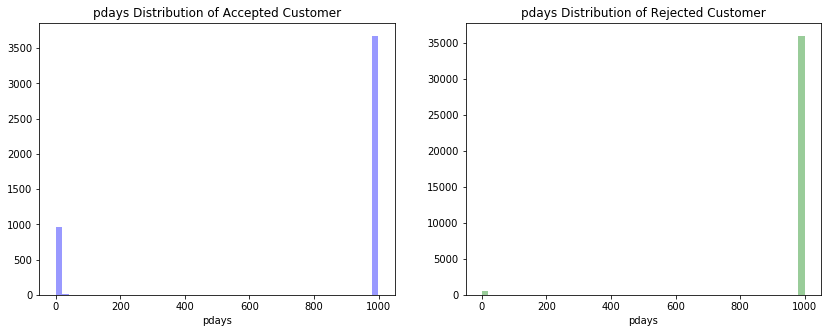

In [19]:
pdaysyes=df['pdays'][df['y']=='yes']
pdaysno=df['pdays'][df['y']=='no']
fig,axes = plt.subplots(1,2,figsize=(14,5))
sns.distplot(pdaysyes, kde=False, color='blue', ax=axes[0]).set_title('pdays Distribution of Accepted Customer')

sns.distplot(pdaysno, kde=False, color='green', ax=axes[1]).set_title('pdays Distribution of Rejected Customer')


Text(0.5, 1.0, 'Euribor Distribution of Rejected Customer')

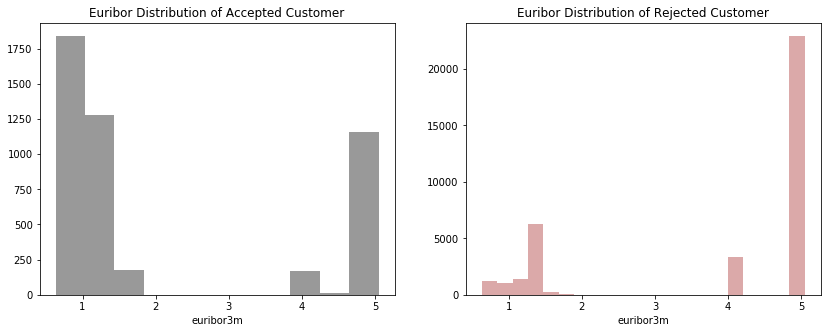

In [20]:
euriboryes=df['euribor3m'][df['y']=='yes']
euriborno=df['euribor3m'][df['y']=='no']
fig,axes = plt.subplots(1,2,figsize=(14,5))
sns.distplot(euriboryes, kde=False, color='black', ax=axes[0]).set_title('Euribor Distribution of Accepted Customer')

sns.distplot(euriborno, kde=False, color='brown', ax=axes[1]).set_title('Euribor Distribution of Rejected Customer')


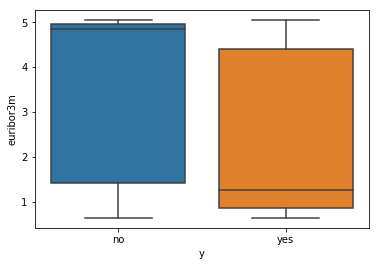

In [21]:
sns.boxplot(df['y'], df['euribor3m'])
plt.show()

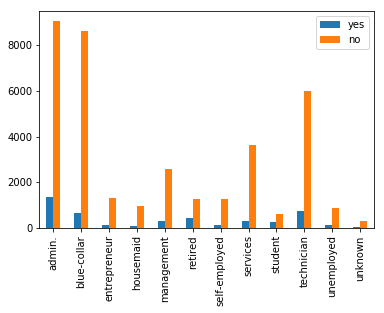

In [22]:
jobyes=df['job'][df['y']=='yes'].value_counts()
jobno=df['job'][df['y']=='no'].value_counts()
job=pd.concat([jobyes,jobno],axis=1)
job.columns=['yes','no']
job.plot(kind='bar')
plt.show()

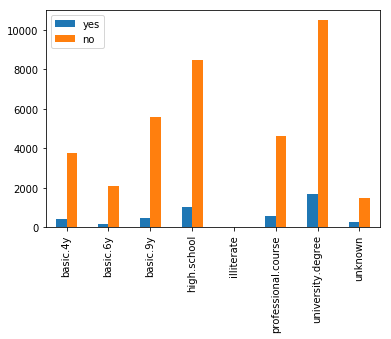

In [23]:
educationyes=df['education'][df['y']=='yes'].value_counts()
educationno=df['education'][df['y']=='no'].value_counts()
education=pd.concat([educationyes,educationno],axis=1)
education.columns=['yes','no']
education.plot(kind='bar')
plt.show()

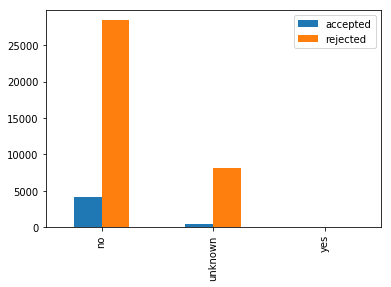

In [24]:
default_yes=df['default'][df['y']=='yes'].value_counts()
default_no=df['default'][df['y']=='no'].value_counts()
default=pd.concat([default_yes,default_no],axis=1)
default.columns=['accepted','rejected']
default.plot(kind='bar')
plt.show()

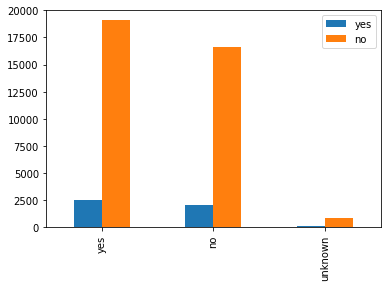

In [25]:
housingyes=df['housing'][df['y']=='yes'].value_counts()
housingno=df['housing'][df['y']=='no'].value_counts()
housing=pd.concat([housingyes,housingno],axis=1)
housing.columns=['yes','no']
housing.plot(kind='bar')
plt.show()

<Figure size 432x288 with 0 Axes>

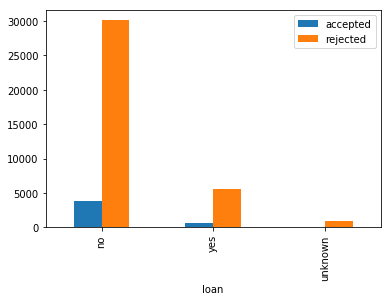

In [26]:
loan_yes=df['loan'][df['y']=='yes'].value_counts()
loan_no=df['loan'][df['y']=='no'].value_counts()
loan=pd.concat([loan_yes,loan_no],axis=1)
plt.figure()
loan.columns=['accepted','rejected']
loan.plot(kind='bar')
plt.xlabel('loan')
plt.show()

<Figure size 432x288 with 0 Axes>

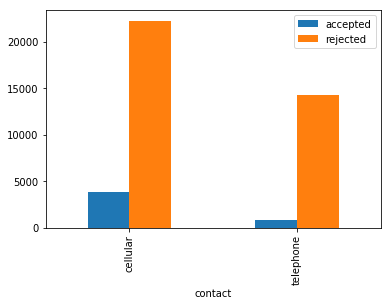

In [27]:
contact_yes=df['contact'][df['y']=='yes'].value_counts()
contact_no=df['contact'][df['y']=='no'].value_counts()
contact=pd.concat([contact_yes,contact_no],axis=1)
plt.figure()
contact.columns=['accepted','rejected']
contact.plot(kind='bar')
plt.xlabel('contact')
plt.show()

<Figure size 432x288 with 0 Axes>

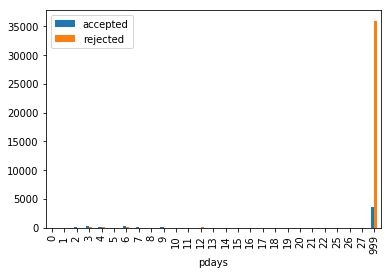

In [28]:
pdays_yes=df['pdays'][df['y']=='yes'].value_counts()
pdays_no=df['pdays'][df['y']=='no'].value_counts()
pdays=pd.concat([pdays_yes,pdays_no],axis=1)
plt.figure()
pdays.columns=['accepted','rejected']
pdays.plot(kind='bar')
plt.xlabel('pdays')
plt.show()

<Figure size 432x288 with 0 Axes>

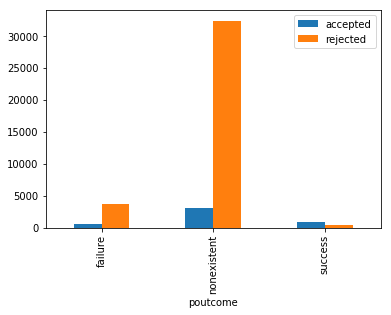

In [29]:
poutcome_yes=df['poutcome'][df['y']=='yes'].value_counts()
poutcome_no=df['poutcome'][df['y']=='no'].value_counts()
poutcome=pd.concat([poutcome_yes,poutcome_no],axis=1)
plt.figure()
poutcome.columns=['accepted','rejected']
poutcome.plot(kind='bar')
plt.xlabel('poutcome')
plt.show()

In [30]:
df.job.unique()

array(['housemaid', 'services', 'admin.', 'blue-collar', 'technician',
       'retired', 'management', 'unemployed', 'self-employed', 'unknown',
       'entrepreneur', 'student'], dtype=object)

In [31]:
df_copy= df.copy()

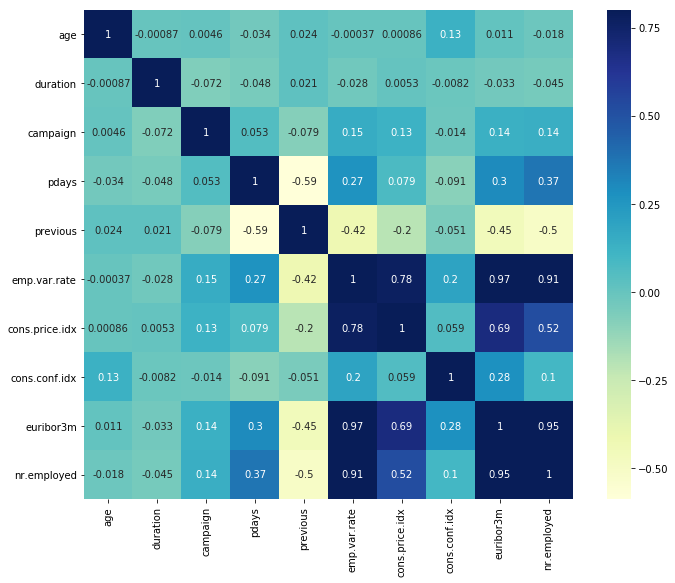

In [32]:
# sns.heatmap(admissn.corr(), annot=True, cmap='BuGn')

f,ax=plt.subplots(figsize= (12,9))
sns.heatmap(df.corr(), vmax=.8 ,square=True, cmap='YlGnBu', annot=True)

In [33]:
# Imputing 'unknown' values

unknwn = ["job", "marital","education", "default", "housing", "loan"]
def mode(i):
    mode= df[i].mode().values[0]
    i = df[i].replace({'unknown' : mode})
    return i

for i in unknwn:
    df[i]= mode(i)

# Statistical tests

In [34]:
from scipy.stats import ttest_1samp,ttest_ind,chi2_contingency,chisquare, f_oneway, levene, bartlett, mannwhitneyu

import statsmodels.api         as     sm
from   statsmodels.formula.api import ols


### t-test ind:
    H0: The mean of are equal. That is they are equally effective
    H1: The mean of are different. That is they are not equally effective
    

In [35]:
for i in df_numerical:
    print(i ,ttest_ind(df_copy[df_copy['y']== 'yes'][i], df_copy[df_copy['y']== 'no'][i])[1])

age 6.80213641846347e-10
duration 0.0
campaign 2.0077799906175704e-41
pdays 0.0
previous 0.0
emp.var.rate 0.0
cons.price.idx 9.318964779954352e-170
cons.conf.idx 7.536664996589982e-29
euribor3m 0.0
nr.employed 0.0


In [36]:
print('pdays',ttest_ind(df_copy[df_copy['y']== 'yes']['pdays'], df_copy[df_copy['y']== 'no']['pdays'])[1])


pdays 0.0


### Chi square hypothesis: 
     H0- There is no association between the two variables
     H1- There is association between the two variables

In [37]:
for i in df_categorical:
    crosstab = pd.crosstab(df['y'], df[i])
    print('P-Value for ',i,'= ',stats.chi2_contingency(crosstab)[1],'\n')

P-Value for  job =  6.808199923441661e-200 

P-Value for  marital =  5.915954286692898e-27 

P-Value for  education =  8.692046071479993e-39 

P-Value for  default =  0.7673035224267515 

P-Value for  housing =  0.025479312776658963 

P-Value for  loan =  0.37633537946635287 

P-Value for  contact =  1.5259856523129964e-189 

P-Value for  month =  0.0 

P-Value for  day_of_week =  2.9584820052785324e-05 

P-Value for  poutcome =  0.0 

P-Value for  y =  0.0 



In [38]:
# Since pvalue for default and loan is > 0.05, we drop these features.
df.drop(['default','loan'], 1, inplace=True)

## Encoding

In [39]:
df.head()

,age,job,marital,education,housing,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,yes,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [40]:
df_categorical = df.select_dtypes(include='object')
for i in df_categorical:
    print(i, df[i].nunique())

job 11
marital 3
education 7
housing 2
contact 2
month 10
day_of_week 5
poutcome 3
y 2


In [41]:
df['y'].replace({'no':1, 'yes':0}, inplace=True)

In [42]:
# Encoding different levels of 'job' feature wrt count of each level.

values = df['job'].value_counts(dropna=False).keys().tolist()
counts = df['job'].value_counts(dropna=False).tolist()
job = dict(zip(values, counts))

manual = [job]

#to sort the count of each class in 'job' feature
import operator
for i in manual:
    sorted_x = sorted(i.items(), key=operator.itemgetter(1))
    sorted_job = sorted_x
    
# encode as per the count of each class in 'job' feature
def fn(a):
    b=[]
    for i in a:
        t=i[0]
        b.append(t)
    t={i:b.index(i) for i in b}
    return t

df['job']= df['job'].replace(fn(sorted_job))

In [43]:
df_copy['education'].unique()

array(['basic.4y', 'high.school', 'basic.6y', 'basic.9y',
       'professional.course', 'unknown', 'university.degree',
       'illiterate'], dtype=object)

In [44]:
#Since eduaction is ordinal field, so encoding it as per different level

df['education'].replace({"illiterate" : 0, "basic.4y" : 1, "basic.6y" : 2, "basic.9y" : 3, "high.school" : 4, 
       "professional.course" : 5, "university.degree" : 6} ,inplace = True)

df['education'] = pd.to_numeric(df['education'],errors='coerce')


In [45]:
# Creating dummies for remaining features

dummy = ['marital',  'housing', 'contact','month', 'day_of_week', 'poutcome']
df = pd.get_dummies(df, prefix=dummy , drop_first=True)
df.head()

,age,job,education,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,marital_married,marital_single,housing_yes,contact_telephone,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success
0,56,2,1,261,1,999,0,1.1,93.994,-36.4,4.857,5191.0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0
1,57,7,4,149,1,999,0,1.1,93.994,-36.4,4.857,5191.0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0
2,37,7,4,226,1,999,0,1.1,93.994,-36.4,4.857,5191.0,1,1,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0
3,40,10,2,151,1,999,0,1.1,93.994,-36.4,4.857,5191.0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0
4,56,7,4,307,1,999,0,1.1,93.994,-36.4,4.857,5191.0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0


In [46]:
df_orgnl = df.copy()

# Models

In [47]:
#classification

x= df.drop('y', 1)
y = df['y']

x_train, x_test, y_train, y_test = train_test_split(x, y,stratify= y,  test_size=0.30, random_state=42)

In [48]:
# Models on origial data

seed= 0
lr= LogisticRegression(max_iter=15000, random_state=seed)
RF= RandomForestClassifier(random_state=seed)
dt= DecisionTreeClassifier(random_state=seed)
bg= BaggingClassifier(random_state=seed)
adb= AdaBoostClassifier(random_state=seed)
gb= GradientBoostingClassifier(random_state=seed)
knn = KNeighborsClassifier()
xgb = XGBClassifier(random_state = seed)
models=[lr,RF, dt,knn, adb, bg, gb, xgb]


def score_ensemble_model(xtrain,ytrain,xtest,ytest):
    mod_columns=[]
    mod=pd.DataFrame(columns=mod_columns)
    i=0
    #read model one by one
    for model in models:
        model.fit(xtrain,ytrain)
        y_pred=model.predict(xtest)
        
        #compute metrics
        train_accuracy=model.score(xtrain,ytrain)
        test_accuracy=model.score(xtest,ytest)
        
        p_score=metrics.precision_score(ytest,y_pred)
        r_score=metrics.recall_score(ytest,y_pred)
        f1_score=metrics.f1_score(ytest,y_pred)
        # calculate the fpr and tpr for all thresholds of the classification
        probs = model.predict_proba(xtest)
        preds = probs[:,1]
        fp, tp, th = metrics.roc_curve(ytest, preds)
        
        #insert in dataframe
        mod.loc[i,"Model_Name"]=model.__class__.__name__
        mod.loc[i,"Precision"]=round(p_score,2)
        mod.loc[i,"Recall"]=round(r_score,2)
        mod.loc[i,"Train_Accuracy"]=round(train_accuracy,2)
        mod.loc[i,"Test_Accuracy"]=round(test_accuracy,2)
        mod.loc[i,"F1_Score"]=round(f1_score,2)
        mod.loc[i,'AUC'] = metrics.auc(fp, tp)
        
        i+=1
    
    #sort values by accuracy
    mod.sort_values(by=['AUC'],ascending=False,inplace=True)
    return(mod)

report=score_ensemble_model(x_train, y_train, x_test, y_test)
report

,Model_Name,Precision,Recall,Train_Accuracy,Test_Accuracy,F1_Score,AUC
6,GradientBoostingClassifier,0.94,0.97,0.92,0.92,0.96,0.949267
7,XGBClassifier,0.94,0.97,0.97,0.92,0.95,0.948600
1,RandomForestClassifier,0.94,0.97,1.00,0.92,0.95,0.945004
4,AdaBoostClassifier,0.93,0.98,0.91,0.91,0.95,0.940162
0,LogisticRegression,0.93,0.98,0.91,0.91,0.95,0.936138
5,BaggingClassifier,0.95,0.95,0.99,0.91,0.95,0.919042
3,KNeighborsClassifier,0.94,0.96,0.93,0.91,0.95,0.876182
2,DecisionTreeClassifier,0.94,0.94,1.00,0.89,0.94,0.731587


# k-fold cross validation

MVLR: 0.068504 (0.000009)
decision tree: 0.260587 (0.000017)
RF: 0.057885 (0.000013)
Adaboost: 0.062235 (0.000010)
bagging: 0.083331 (0.000030)
gradient: 0.053239 (0.000006)
knn: 0.127696 (0.000023)
XGB: 0.052543 (0.000008)


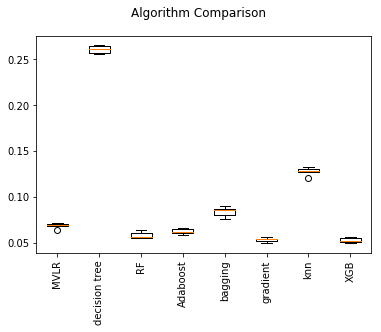

In [49]:
# evaluate each model in turn
import sklearn.model_selection as model_selection

results = []
names = []

models = []
models.append(('MVLR', lr))
models.append(('decision tree', dt))
models.append(('RF', RF))
models.append(('Adaboost', adb))
models.append(('bagging', bg))
models.append(('gradient', gb))
models.append(('knn', knn))
models.append(('XGB', xgb))


for name, model in models:
    kfold = model_selection.KFold(shuffle=True,n_splits=5,random_state=0)
    cv_results = model_selection.cross_val_score(model, x,y,cv=kfold, scoring='roc_auc')
    results.append(cv_results)
    names.append(name)
    print("%s: %f (%f)" % (name, 1- np.mean(cv_results),np.var(cv_results,ddof=1)))

# bias calculation
bias= []
for i in list(results):
    bias.append(1- i)
    

# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(bias)
ax.set_xticklabels(names)
plt.xticks(rotation = 90)
plt.show()

In [50]:
# final model
gb.fit(x_train, y_train)

y_pred=  gb.predict(x_test)

print(confusion_matrix(y_test, y_pred))
      
print(classification_report(y_test, y_pred)) #76 48 tuned

[[  709   683]
 [  319 10646]]
              precision    recall  f1-score   support

           0       0.69      0.51      0.59      1392
           1       0.94      0.97      0.96     10965

    accuracy                           0.92     12357
   macro avg       0.81      0.74      0.77     12357
weighted avg       0.91      0.92      0.91     12357



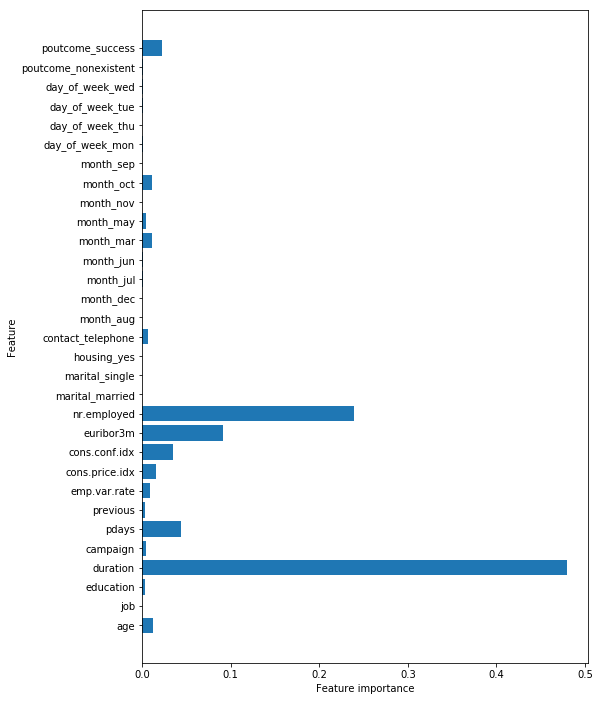

In [51]:
def plot_feature_importances(model):
    '''
    Visualization for future importance
    '''
    n_features = x_train.shape[1]
    plt.figure(figsize=(8,12))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), x.columns.values) 
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    
plot_feature_importances(gb)
